# Task 1: implementation

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation


1. Websites that have the largest count of news articles

In [3]:

# Load the data
data_df = pd.read_csv('C:\\Users\\araso\\Documents\\10academy\\data\\data.csv')
domains_location_df = pd.read_csv('C:\\Users\\araso\\Documents\\10academy\\data\\domains_location.csv')
traffic_data_df = pd.read_csv('C:\\Users\\araso\\Documents\\10academy\\data\\traffic.csv')
rating_df = pd.read_csv('C:\\Users\\araso\\Documents\\10academy\\data\\rating.csv')

# Merge data.csv with domains_location.csv
data_with_location = pd.merge(data_df, domains_location_df, left_on='source_name', right_on='SourceCommonName', how='left')

# Merge the result with traffic_data.csv
full_data = pd.merge(data_with_location, traffic_data_df, left_on='SourceCommonName', right_on='Domain', how='left')

# 1. Websites that have the largest count of news articles
article_counts = data_df['source_name'].value_counts()
top_10_websites_articles = article_counts.head(10)
bottom_10_websites_articles = article_counts.tail(10)

# Display the results
print("Top 10 Websites by Article Count:")
print(top_10_websites_articles)
print("\nBottom 10 Websites by Article Count:")
print(bottom_10_websites_articles)


Top 10 Websites by Article Count:
source_name
ETF Daily News        16631
The Times of India     7629
GlobeNewswire          5485
Forbes                 4423
Biztoc.com             3968
BBC News               3342
Globalsecurity.org     3093
Business Insider       2746
ABC News               2188
Marketscreener.com     1948
Name: count, dtype: int64

Bottom 10 Websites by Article Count:
source_name
Powerdns.com           1
Frame.work             1
Dannymekic.com         1
Dougwils.com           1
Linuxgizmos.com        1
Paranatural.net        1
Duringquiettime.com    1
Askmen.com             1
Elementy.ru            1
Caltech.edu            1
Name: count, dtype: int64


2. Websites with the highest numbers of visitors traffic

In [22]:
# 2. Websites with the highest numbers of visitors traffic
top_10_websites_traffic = traffic_data_df.sort_values(by='GlobalRank').head(10)[['Domain', 'GlobalRank']]
bottom_10_websites_traffic = traffic_data_df.sort_values(by='GlobalRank').tail(10)[['Domain', 'GlobalRank']]

print("\nTop 10 Websites by Visitor Traffic:")
print(top_10_websites_traffic)
print("\nBottom 10 Websites by Visitor Traffic:")
print(bottom_10_websites_traffic)


Top 10 Websites by Visitor Traffic:
                 Domain  GlobalRank
0            google.com           1
1          facebook.com           2
2           youtube.com           3
3           twitter.com           4
4         instagram.com           5
5          linkedin.com           6
6             apple.com           7
7         microsoft.com           8
8  googletagmanager.com           9
9         wikipedia.org          10

Bottom 10 Websites by Visitor Traffic:
                        Domain  GlobalRank
999990            eiretrip.com      999991
999991    exploring-africa.com      999992
999992                hmag.com      999993
999993          irishcycle.com      999994
999994         keith-baker.com      999995
999995              kireie.com      999996
999996             mt-lock.com      999997
999997           pinkwater.com      999998
999998          soderhomes.com      999999
999999  toyotamusicfactory.com     1000000


3. Countries with the highest number of news media organisations (represented by domains in the data)

In [23]:
# 3. Countries with the highest number of news media organisations (represented by domains in the data)
country_domain_counts = domains_location_df['Country'].value_counts()
top_10_countries_domains = country_domain_counts.head(10)
bottom_10_countries_domains = country_domain_counts.tail(10)

print("\nTop 10 Countries by Number of Media Organisations:")
print(top_10_countries_domains)
print("\nBottom 10 Countries by Number of Media Organisations:")
print(bottom_10_countries_domains)


Top 10 Countries by Number of Media Organisations:
Country
United States     14111
United Kingdom     1950
Italy              1810
France             1041
Russia             1024
Canada              887
Germany             884
China               780
Turkey              725
India               686
Name: count, dtype: int64

Bottom 10 Countries by Number of Media Organisations:
Country
American Samoa              1
Micronesia                  1
Mayotte                     1
Isle of Man                 1
Guernsey                    1
West Bank                   1
Pitcairn Islands            1
Oceans                      1
Turks and Caicos Islands    1
Saint Helena                1
Name: count, dtype: int64


4. Countries with Many Articles Written About Them

In [36]:
# 4. Countries that have many articles written about them
# We will check if the country names are mentioned in the article content

# List of countries to check in the content
countries_list = domains_location_df['Country'].unique()

# Initialize a dictionary to count articles per country
country_article_count = {country: 0 for country in countries_list}

# Count occurrences of each country in the article content
for country in countries_list:
    country = str(country)
    country_article_count[country] = data_df['content'].str.contains(country, case=False, na=False).sum()

# Convert dictionary to DataFrame
country_article_count_df = pd.DataFrame(list(country_article_count.items()), columns=['Country', 'ArticleCount']).dropna()

# Sort by ArticleCount to find the top and bottom 10 countries
top_10_countries_articles = country_article_count_df.sort_values(by='ArticleCount', ascending=False).head(10)
bottom_10_countries_articles = country_article_count_df.sort_values(by='ArticleCount', ascending=True).tail(10)

# Display the results
print("Top 10 Countries by Article Count:")
print(top_10_countries_articles)

print("\nBottom 10 Countries by Article Count:")
print(bottom_10_countries_articles)

{'Senegal': np.int64(52), 'France': np.int64(600), 'Italy': np.int64(355), 'Argentina': np.int64(222), 'China': np.int64(1773), 'Germany': np.int64(467), 'Ukraine': np.int64(1289), 'United States': np.int64(1614), 'Russia': np.int64(2089), 'Egypt': np.int64(295), 'India': np.int64(3746), 'Taiwan': np.int64(241), 'United Kingdom': np.int64(190), 'Canada': np.int64(868), 'South Africa': np.int64(540), 'Greece': np.int64(144), 'Netherlands': np.int64(249), 'Chile': np.int64(90), 'Iran': np.int64(1079), 'Cuba': np.int64(114), 'Lithuania': np.int64(113), 'Hungary': np.int64(134), 'Uruguay': np.int64(66), 'Brazil': np.int64(309), 'Switzerland': np.int64(159), 'Armenia': np.int64(224), 'Indonesia': np.int64(282), 'Azerbaijan': np.int64(191), 'Bangladesh': np.int64(185), 'Georgia': np.int64(275), 'Tuvalu': np.int64(10), 'Venezuela': np.int64(131), 'Spain': np.int64(364), 'Latvia': np.int64(78), 'Cameroon': np.int64(58), 'Mexico': np.int64(392), 'United Arab Emirates': np.int64(152), 'Portugal'

5. Websites that reported about Africa, US, China, EU, Russia, Ukraine, Middle East

In [38]:
# 5. Websites that reported about Africa, US, China, EU, Russia, Ukraine, Middle East

# Define country groups for each region
african_countries = domains_location_df[domains_location_df['location'].isin(['DZ', 'AO', 'BJ', 'BW', 'BF', 'BI', 'CV', 'CM', 'CF', 'TD', 'KM', 'CG', 'CD', 'DJ', 'EG', 'GQ', 'ER', 'SZ', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 'KE', 'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR', 'MU', 'YT', 'MA', 'MZ', 'NA', 'NE', 'NG', 'RE', 'RW', 'SH', 'ST', 'SN', 'SC', 'SL', 'SO', 'ZA', 'SS', 'SD', 'TZ', 'TG', 'TN', 'UG', 'EH', 'ZM', 'ZW'])]['SourceCommonName'].unique()

eu_countries = domains_location_df[domains_location_df['location'].isin(['AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IE', 'IT', 'LV', 'LT', 'LU', 'MT', 'NL', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE'])]['SourceCommonName'].unique()

middle_east_countries = domains_location_df[domains_location_df['location'].isin(['BH', 'EG', 'IR', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'PS', 'QA', 'SA', 'SY', 'AE', 'YE'])]['SourceCommonName'].unique()

# Initialize dictionaries for each region
africa_article_count = 0
us_article_count = 0
china_article_count = 0
eu_article_count = 0
russia_article_count = 0
ukraine_article_count = 0
middle_east_article_count = 0

# Check occurrences for each region in the article content
africa_article_count = data_df['content'].apply(lambda x: any(country in x for country in african_countries)).sum()
us_article_count = data_df['content'].str.contains('US', case=False, na=False).sum()
china_article_count = data_df['content'].str.contains('China', case=False, na=False).sum()
eu_article_count = data_df['content'].apply(lambda x: any(country in x for country in eu_countries)).sum()
russia_article_count = data_df['content'].str.contains('Russia', case=False, na=False).sum()
ukraine_article_count = data_df['content'].str.contains('Ukraine', case=False, na=False).sum()
middle_east_article_count = data_df['content'].apply(lambda x: any(country in x for country in middle_east_countries)).sum()

# Aggregate the article counts for each region
region_article_count = {
    'Africa': africa_article_count,
    'US': us_article_count,
    'China': china_article_count,
    'EU': eu_article_count,
    'Russia': russia_article_count,
    'Ukraine': ukraine_article_count,
    'Middle East': middle_east_article_count
}

region_article_count_df = pd.DataFrame(list(region_article_count.items()), columns=['Region', 'ArticleCount'])

# Sort and display the top and bottom 10 websites for these regions
top_10_region_articles = region_article_count_df.sort_values(by='ArticleCount', ascending=False).head(10)
bottom_10_region_articles = region_article_count_df.sort_values(by='ArticleCount', ascending=True).head(10)


print("\nTop 10 Regions by Article Count:")
print(top_10_region_articles)

print("\nBottom 10 Regions by Article Count:")
print(bottom_10_region_articles)



Top 10 Regions by Article Count:
        Region  ArticleCount
3           EU             2
6  Middle East             2
0       Africa            20
5      Ukraine          1289
2        China          1773
4       Russia          2089
1           US         39028

Bottom 10 Regions by Article Count:
        Region  ArticleCount
3           EU             2
6  Middle East             2
0       Africa            20
5      Ukraine          1289
2        China          1773
4       Russia          2089
1           US         39028


6. Websites with the highest count of positive, neutral, and negative sentiment? To do this you will need to group the data by website domain and apply descriptive statistics such as mean, median, and variance

In [44]:

# Convert sentiment to numeric values for descriptive statistics
sentiment_mapping = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
rating_df['title_sentiment_numeric'] = rating_df['title_sentiment'].map(sentiment_mapping)

# Group by domain and calculate descriptive statistics
sentiment_stats = rating_df.groupby('source_name')['title_sentiment_numeric'].agg(
    mean_sentiment=np.mean,
    median_sentiment=np.median,
    variance_sentiment=np.var,
    count='count'
).reset_index()

# Identify top 10 domains by visitor traffic
top_10_traffic_domains = traffic_data_df.sort_values(by='GlobalRank').head(10)['Domain']

# Filter sentiment statistics for these top 10 domains
top_10_sentiment_stats = sentiment_stats[sentiment_stats['source_name'].isin(top_10_traffic_domains)]

# Global sentiment distribution
global_sentiment_distribution = rating_df['title_sentiment'].value_counts(normalize=True)

# Sentiment distribution for top 10 domains
top_10_domains_sentiment_distribution = rating_df[rating_df['source_name'].isin(top_10_traffic_domains)]['title_sentiment'].value_counts(normalize=True)

# Display the results
print("Sentiment Statistics (Mean, Median, Variance) for Each Website Domain:")
print(sentiment_stats.sort_values(by='mean_sentiment', ascending=False))

print("\nComparison of Sentiment Distribution:")
print("Global Sentiment Distribution:")
print(global_sentiment_distribution)
print("\nTop 10 Domains Sentiment Distribution:")
print(top_10_domains_sentiment_distribution)

print("\nTop 10 Domains by Traffic with Sentiment Statistics:")
print(top_10_sentiment_stats)


C:\Users\araso\AppData\Local\Temp\ipykernel_10996\768383721.py:6: FutureWarning: The provided callable <function mean at 0x000002E06CACDAB0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sentiment_stats = rating_df.groupby('source_name')['title_sentiment_numeric'].agg(
C:\Users\araso\AppData\Local\Temp\ipykernel_10996\768383721.py:6: FutureWarning: The provided callable <function median at 0x000002E07EBEE290> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  sentiment_stats = rating_df.groupby('source_name')['title_sentiment_numeric'].agg(
C:\Users\araso\AppData\Local\Temp\ipykernel_10996\768383721.py:6: FutureWarning: The provided callable <function var at 0x000002E06CACDCF0> is currently using SeriesGroupBy.var. In a future version 

Sentiment Statistics (Mean, Median, Variance) for Each Website Domain:
                     source_name  mean_sentiment  median_sentiment  \
10                Digital Trends        0.463010               1.0   
3                Android Central        0.448276               1.0   
16                 GlobeNewswire        0.161903               0.0   
13                        Forbes        0.150503               0.0   
26                     The Verge        0.121495               0.0   
22                     ReadWrite        0.098765               0.0   
18            Marketscreener.com        0.081498               0.0   
11                ETF Daily News        0.025797               0.0   
28                         Wired        0.007407               0.0   
25            The Times of India       -0.008662               0.0   
9                       Deadline       -0.032189               0.0   
14                   Gizmodo.com       -0.043814               0.0   
7                  

7. Similarity of Raw Message Lengths Across Sites and How similar are the number of words in the title across sites? Check the distribution among sites

c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6044 (\N{KHMER LETTER VO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6072 (\N{KHMER VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6050 (\N{KHMER LETTER QA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6076 (\N{KHMER VOWEL SIGN UU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 

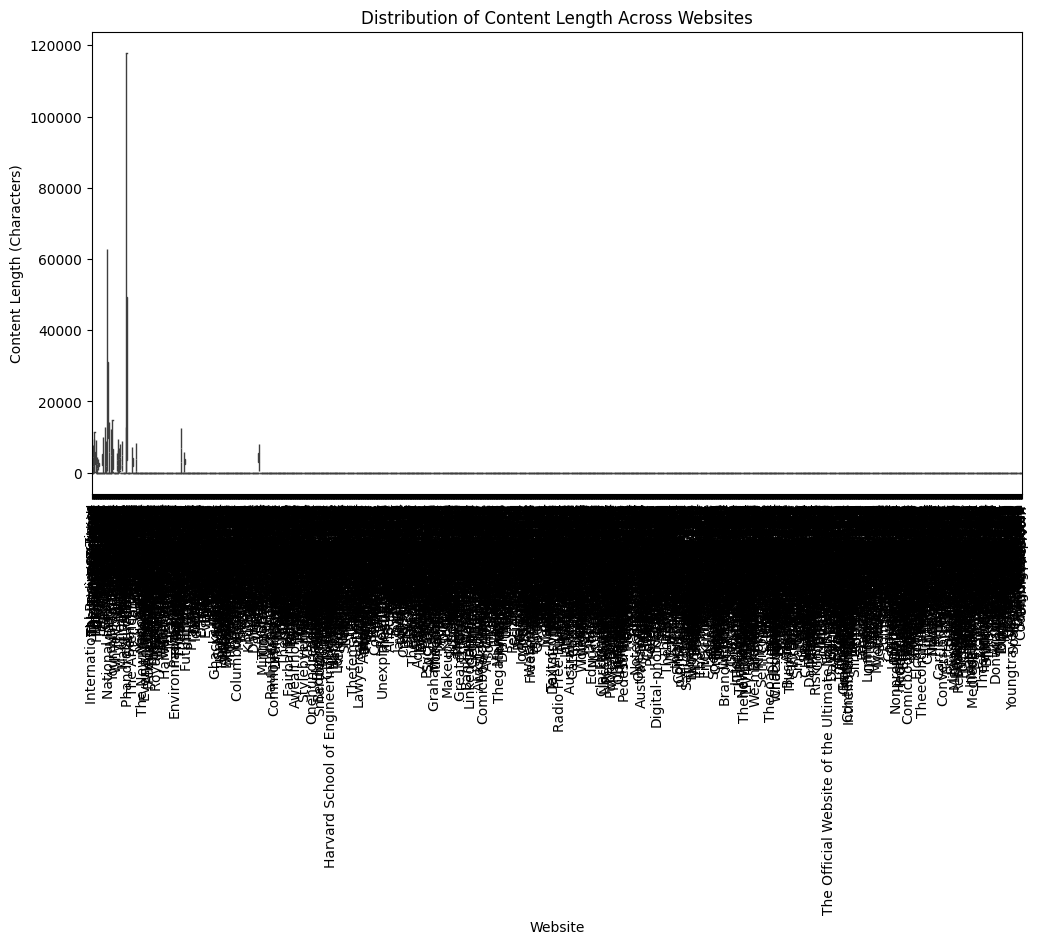

c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6044 (\N{KHMER LETTER VO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6072 (\N{KHMER VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6050 (\N{KHMER LETTER QA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6076 (\N{KHMER VOWEL SIGN UU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 

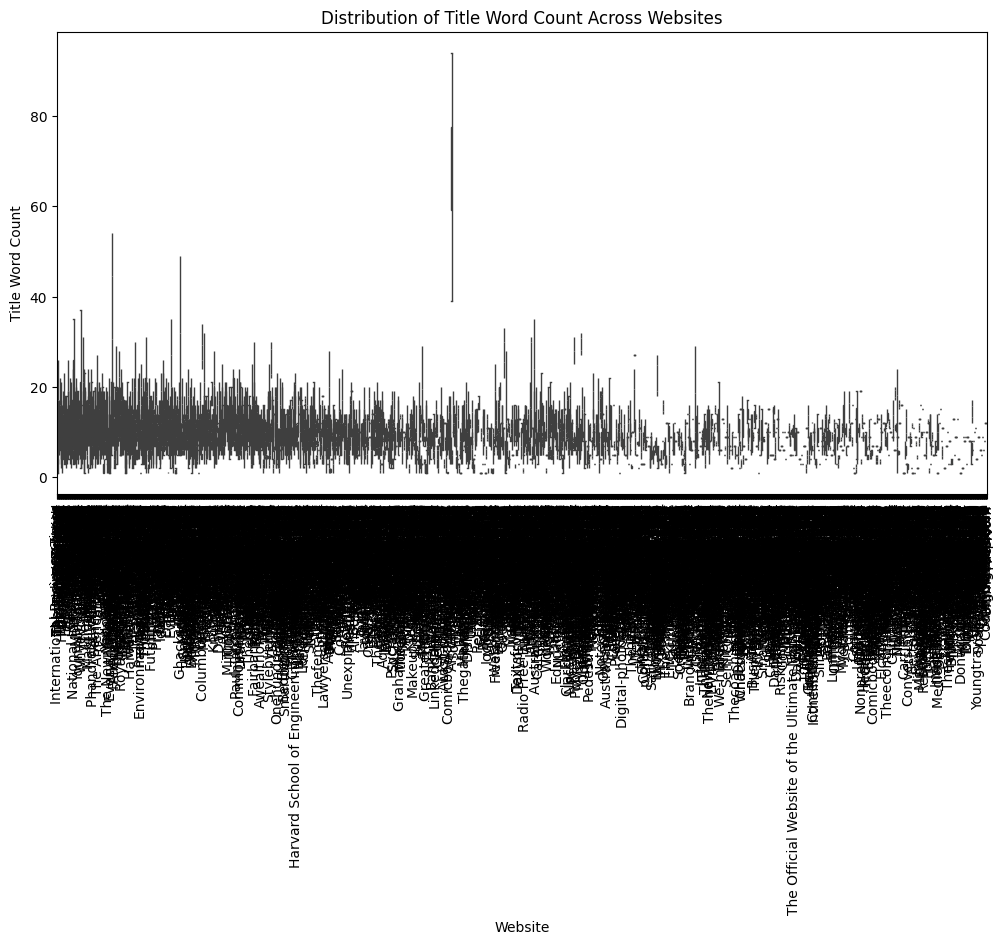

Descriptive Statistics of Content Length Across Sites:
                        count  mean  std  min  25%  50%  75%  max
source_name                                                      
/FILM                   142.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
1000wordphilosophy.com    1.0   3.0  NaN  3.0  3.0  3.0  3.0  3.0
100daysofrealfood.com     9.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
100layercake.com          2.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
101cookbooks.com         10.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
...                       ...   ...  ...  ...  ...  ...  ...  ...
thechalkboardmag.com      2.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
thereformedbroker.com     3.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
tomandlorenzo.com        10.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
tor.com                  18.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
វីអូអេ - VOA Khmer        6.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0

[2379 rows x 8 columns]

Descriptive Statistics of Title Word Count Across Sites:
    

In [52]:

# Ensure that the title and full_content columns are treated as strings and handle missing values
data_df['title'] = data_df['title'].astype(str)
data_df['full_content'] = data_df['full_content'].astype(str)

# Similarity of Raw Message Lengths Across Sites
# Calculate the length of the full content for each article
data_df['content_length'] = data_df['full_content'].apply(lambda x: len(x) if x else 0)

# Group by source_name to compare distributions
content_length_distribution = data_df.groupby('source_name')['content_length'].describe()

# Plot the distribution of content length for top websites
plt.figure(figsize=(12, 6))
sns.boxplot(x='source_name', y='content_length', data=data_df, showfliers=False)
plt.title('Distribution of Content Length Across Websites')
plt.xlabel('Website')
plt.ylabel('Content Length (Characters)')
plt.xticks(rotation=90)
plt.show()

# Similarity of the Number of Words in the Title Across Sites
# Calculate the number of words in the title for each article
data_df['title_word_count'] = data_df['title'].apply(lambda x: len(x.split()) if x else 0)

# Group by source_name to compare distributions
title_word_count_distribution = data_df.groupby('source_name')['title_word_count'].describe()

# Plot the distribution of title word count for top websites
plt.figure(figsize=(12, 6))
sns.boxplot(x='source_name', y='title_word_count', data=data_df, showfliers=False)
plt.title('Distribution of Title Word Count Across Websites')
plt.xlabel('Website')
plt.ylabel('Title Word Count')
plt.xticks(rotation=90)
plt.show()

# Display descriptive statistics for both analyses
print("Descriptive Statistics of Content Length Across Sites:")
print(content_length_distribution)

print("\nDescriptive Statistics of Title Word Count Across Sites:")
print(title_word_count_distribution)


8. Do a 2D scatter plot where x-axis is the total number of reports by a website, y-axis is the global ranking of the site, and the color representing average/median sentiment. 

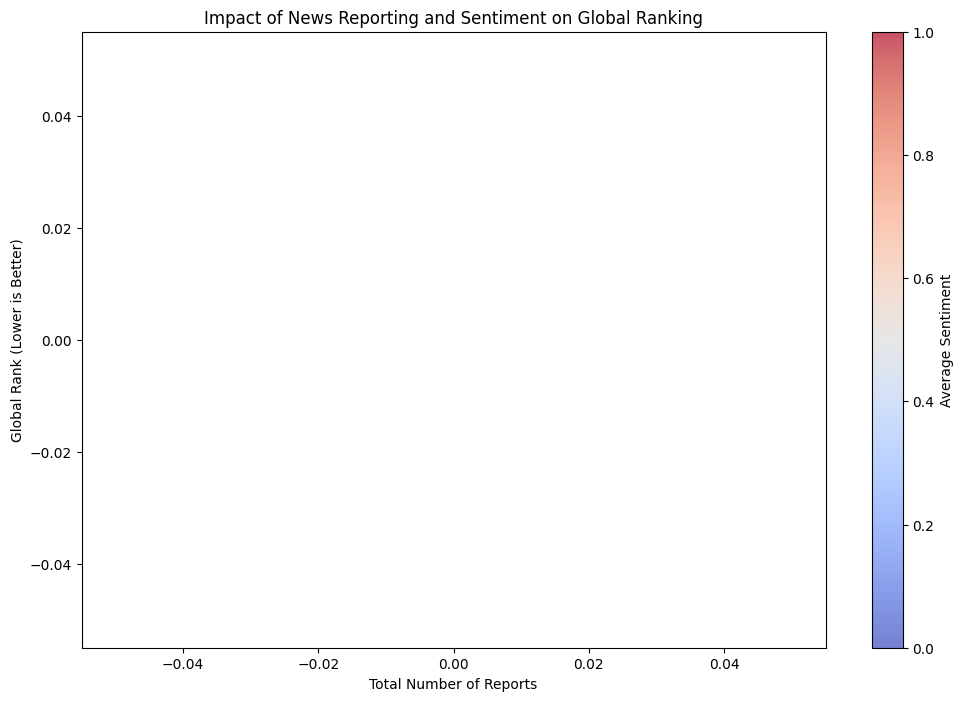

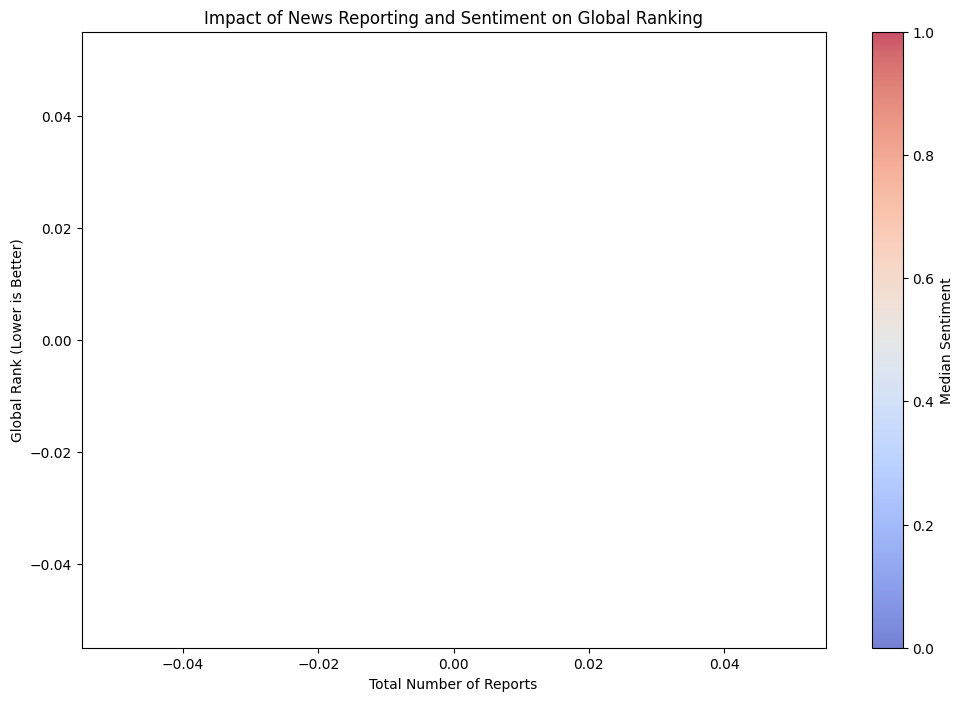

In [55]:

# Calculate the total number of reports by each website
report_counts = rating_df.groupby('source_name').size().reset_index(name='total_reports')

# Calculate the average and median sentiment for each website
sentiment_agg = rating_df.groupby('source_name')['title_sentiment_numeric'].agg(
    avg_sentiment='mean',
    median_sentiment='median'
).reset_index()

# Merge with traffic data to get the global ranking
merged_data = pd.merge(report_counts, sentiment_agg, on='source_name')
merged_data = pd.merge(merged_data, traffic_data_df[['Domain', 'GlobalRank']], left_on='source_name', right_on='Domain')

# Plot the 2D scatter plot with average sentiment
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=merged_data['total_reports'],
    y=merged_data['GlobalRank'],
    c=merged_data['avg_sentiment'],
    cmap='coolwarm',
    s=100,
    alpha=0.7
)
plt.colorbar(scatter, label='Average Sentiment')
plt.xlabel('Total Number of Reports')
plt.ylabel('Global Rank (Lower is Better)')
plt.title('Impact of News Reporting and Sentiment on Global Ranking')
plt.show()

# Plot the 2D scatter plot with median sentiment
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=merged_data['total_reports'],
    y=merged_data['GlobalRank'],
    c=merged_data['median_sentiment'],
    cmap='coolwarm',
    s=100,
    alpha=0.7
)
plt.colorbar(scatter, label='Median Sentiment')
plt.xlabel('Total Number of Reports')
plt.ylabel('Global Rank (Lower is Better)')
plt.title('Impact of News Reporting and Sentiment on Global Ranking')
plt.show()


# Task 2: Implementation

1. Perform Keyword extraction/modelling using TF-IDF

In [10]:
# Function to extract top n keywords using TF-IDF
def extract_keywords_tfidf(texts, n=5):
    vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    top_keywords = []

    for i in range(tfidf_matrix.shape[0]):
        tfidf_scores = tfidf_matrix[i].T.todense()
        sorted_indices = tfidf_scores.argsort(axis=0)[::-1]
        top_n = [feature_names[index[0, 0]] for index in sorted_indices[:n]]
        top_keywords.append(top_n)
    
    return top_keywords

# Extract keywords for titles and full content
data_df['title_keywords'] = extract_keywords_tfidf(data_df['title'].fillna(''), n=5)
data_df['content_keywords'] = extract_keywords_tfidf(data_df['full_content'].fillna(''), n=5)


# Function to calculate cosine similarity between two lists of keywords
def calculate_similarity(keywords1, keywords2):
    vectorizer = TfidfVectorizer().fit([' '.join(keywords1), ' '.join(keywords2)])
    tfidf_matrix = vectorizer.transform([' '.join(keywords1), ' '.join(keywords2)])
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]


# Calculate similarity between title and content keywords across sites
data_df['keyword_similarity'] = data_df.apply(lambda row: calculate_similarity(row['title_keywords'], row['content_keywords']), axis=1)

# Analyze similarity by site
similarity_by_site = data_df.groupby('source_name')['keyword_similarity'].mean().reset_index()

# Display the results
print("Similarity of Keywords in Titles and Content Across Sites:")
print(similarity_by_site.sort_values(by='keyword_similarity', ascending=False))


Similarity of Keywords in Titles and Content Across Sites:
          source_name  keyword_similarity
103   Android Central            0.223835
540    Digital Trends            0.203151
1531         Phys.Org            0.190045
1624        ReadWrite            0.186588
1991        The Verge            0.174520
...               ...                 ...
22            9to5Mac            0.000000
23           9to5Toys            0.000000
24       9to5chic.com            0.000000
25     9to5google.com            0.000000
2347    cleveland.com            0.000000

[2379 rows x 2 columns]


In [12]:
def clean_data(df):
    # Fill missing values
    df['title'] = df['title'].fillna('')
    df['full_content'] = df['full_content'].fillna('')
    
    # Ensure correct data types
    df['title'] = df['title'].astype(str)
    df['full_content'] = df['full_content'].astype(str)
    df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')
    
    # Drop rows with invalid dates
    df = df.dropna(subset=['published_at'])
    
    return df

# Load and clean data
data_df = clean_data(data_df)

2. Perform topic modelling.

2. 1 categorise the title/content into a known set of topic categories

In [28]:
import sys
sys.path.append('../')

from scripts.topic_modeling import *

# Perform topic modeling
n_topics = 10  # Number of topics to identify
lda, topics, vectorizer = perform_topic_modeling_by_lda(data_df, n_topics=n_topics)

# Assign the most likely topic to each article
topic_assignments = lda.transform(vectorizer.transform(data_df['text'])).argmax(axis=1)
data_df['topic'] = topic_assignments


KeyboardInterrupt: 

2. 2 Which websites reported the most diverse topics?

In [21]:
def analyze_topic_diversity(df):
    # Calculate the number of unique topics reported by each website
    diversity = df.groupby('source_name')['topic'].nunique().reset_index()
    diversity.columns = ['source_name', 'unique_topics']
    
    # Sort by most diverse topics
    most_diverse_sites = diversity.sort_values(by='unique_topics', ascending=False)
    
    return most_diverse_sites

# Analyze topic diversity
most_diverse_sites = analyze_topic_diversity(data_df)
print("Websites Reporting the Most Diverse Topics:")
print(most_diverse_sites.head(10))


Websites Reporting the Most Diverse Topics:
            source_name  unique_topics
13            3dnews.ru             10
391       Cointelegraph             10
277   Bringatrailer.com             10
534            Die Zeit             10
582            EURACTIV             10
579                ESPN             10
539     Digital Journal             10
627         Eonline.com             10
1994  The Week Magazine             10
1987    The Star Online             10


2. 3 Analyse the topic trends. 

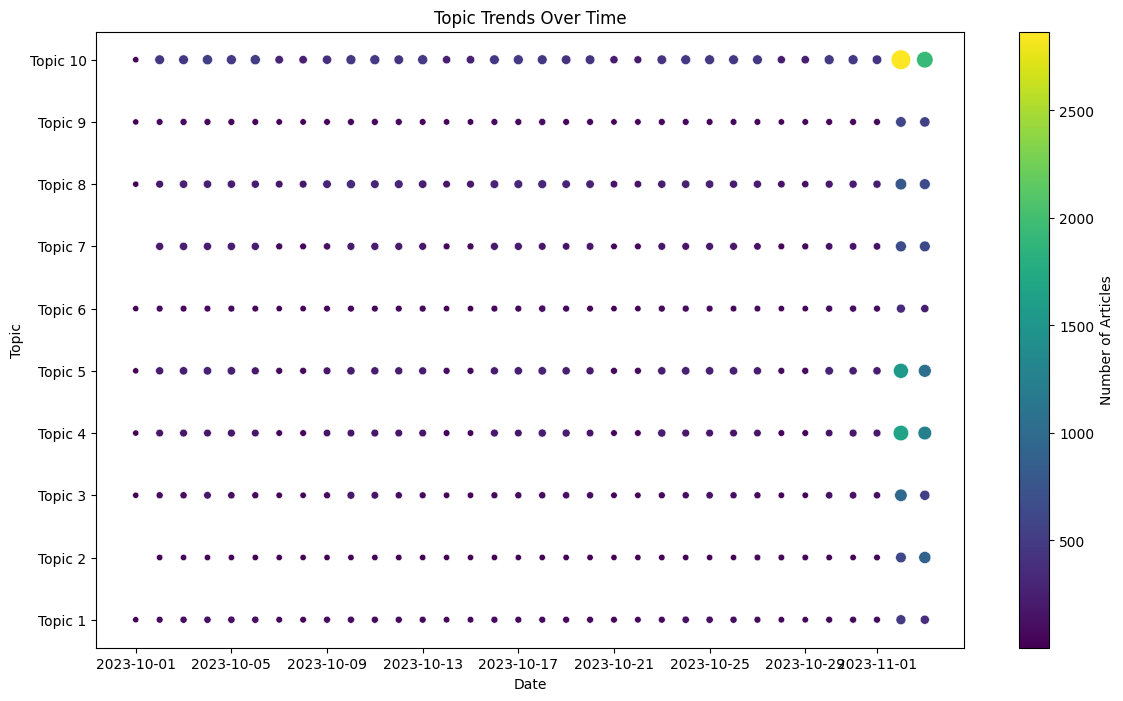

In [26]:

def plot_topic_trends(df, n_topics):
    # Group by date and topic, then count the occurrences
    trend_data = df.groupby([df['published_at'].dt.date, 'topic']).size().reset_index(name='count')
    
    # Plot the trends
    plt.figure(figsize=(14, 8))
    ax = plt.gca()  # Get the current axis
    scatter = sns.scatterplot(data=trend_data, x='published_at', y='topic', size='count', hue='count', palette='viridis', sizes=(20, 200), legend=False, ax=ax)

    # Manually create the colorbar
    norm = plt.Normalize(trend_data['count'].min(), trend_data['count'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    
    # Add the colorbar to the correct axis
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Number of Articles')
    
    plt.title('Topic Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Topic')
    plt.yticks(range(n_topics), labels=[f'Topic {i+1}' for i in range(n_topics)])
    plt.show()

# Plot topic trends
plot_topic_trends(data_df, n_topics=n_topics)



3. Model the events that the news articles are written about

In [16]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Convert to lower case
    text = text.lower()
    # Remove extra spaces
    text = text.strip()
    return text

def prepare_data(df):
    # Clean text data and combine title and content
    df['title'] = df['title'].fillna('').apply(clean_text)
    df['full_content'] = df['full_content'].fillna('').apply(clean_text)
    df['text'] = df['title'] + " " + df['full_content']
    return df

# Load and prepare data
data_df = prepare_data(data_df)

def vectorize_text(df):
    # Fill NaN values with empty strings to avoid errors during vectorization
    df['text'] = df['text'].fillna('')
    
    # Use TF-IDF to vectorize the text data
    vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english', max_features=10000)
    tfidf_matrix = vectorizer.fit_transform(df['text'])
    return tfidf_matrix, vectorizer

# Vectorize the text data
tfidf_matrix, vectorizer = vectorize_text(data_df)

def cluster_texts(tfidf_matrix, num_clusters=10):
    # Apply K-Means clustering
    km = KMeans(n_clusters=num_clusters, random_state=42)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    return km, clusters

# Determine the number of clusters
num_clusters = 10

# Perform clustering
kmeans_model, clusters = cluster_texts(tfidf_matrix, num_clusters)
data_df['cluster'] = clusters

def get_top_keywords(cluster_centers, vectorizer, top_n=10):
    keywords = []
    for i, cluster_center in enumerate(cluster_centers):
        top_indices = cluster_center.argsort()[-top_n:]
        top_keywords = [vectorizer.get_feature_names_out()[index] for index in top_indices]
        keywords.append(top_keywords)
    return keywords

# Get top keywords for each cluster
top_keywords = get_top_keywords(kmeans_model.cluster_centers_, vectorizer, top_n=10)

# Assign event descriptions based on top keywords
data_df['event_description'] = data_df['cluster'].apply(lambda x: ', '.join(top_keywords[x]))

# Display the event descriptions
for i, keywords in enumerate(top_keywords):
    print(f"Event {i+1}: {', '.join(keywords)}")

# Analyze the number of articles and media covering each event
event_analysis = data_df.groupby(['cluster', 'event_description']).agg(
    num_articles=('article_id', 'count'),
    num_media=('source_name', 'nunique')
).reset_index()

# Display the event analysis
print("Event Analysis:")
print(event_analysis.sort_values(by='num_articles', ascending=False))


C:\Users\araso\AppData\Local\Temp\ipykernel_18992\347042450.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].fillna('').apply(clean_text)
C:\Users\araso\AppData\Local\Temp\ipykernel_18992\347042450.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_content'] = df['full_content'].fillna('').apply(clean_text)
C:\Users\araso\AppData\Local\Temp\ipykernel_18992\347042450.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Event 1: switch, samsung, coffee, wireless, games, speakers, game, nintendo, deals, amazon
Event 2: southeast, schemes, people, criminals, china, cyber, zhang, myanmar, scam, chinese
Event 3: people, october, company, says, shares, ai, world, israel, said, new
Event 4: aruba, disappearance, murder, admits, suspect, sloot, van, holloway, natalee, der
Event 5: movie, universe, doctor, season, marvel, new, film, trek, wars, star
Event 6: federal, campaign, guilty, charges, vote, rep, expel, house, george, santos
Event 7: asia, heights, quarter, shares, cycles, campus, ties, university, banking, columbia
Event 8: help, stack, google, skills, october, assistant, bard, ai, programming, coding
Event 9: climate, whales, key, size, paper, debate, saving, fish, antarctica, clip
Event 10: viewed, west, relax, captures, media, windows, baby, realize, video, moment
Event Analysis:
   cluster                                  event_description  num_articles  \
2        2  people, october, company, sa

C:\Users\araso\AppData\Local\Temp\ipykernel_18992\347042450.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['event_description'] = data_df['cluster'].apply(lambda x: ', '.join(top_keywords[x]))


In [19]:


# Clean and prepare the data
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower().strip()
    return text

data_df['title'] = data_df['title'].apply(clean_text)
data_df['full_content'] = data_df['full_content'].apply(clean_text)
data_df['text'] = data_df['title'] + " " + data_df['full_content']

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english', max_features=10000)
tfidf_matrix = vectorizer.fit_transform(data_df['text'])

# Apply K-Means clustering to group articles into events
num_clusters = 10  # Adjust the number of clusters based on the dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)
data_df['event_cluster'] = kmeans.labels_

# 1. How many events are covered in the data?
num_events = data_df['event_cluster'].nunique()
print(f"Number of events covered in the data: {num_events}")

# 2. Which news sites report events the earliest?
data_df['published_at'] = pd.to_datetime(data_df['published_at'], errors='coerce')
earliest_reports = data_df.groupby(['event_cluster', 'source_name'])['published_at'].min().reset_index()
earliest_site_per_event = earliest_reports.loc[earliest_reports.groupby('event_cluster')['published_at'].idxmin()]
print("Earliest reporting news sites per event:")
print(earliest_site_per_event)

# 3. Which events have the highest reporting?
event_reporting = data_df['event_cluster'].value_counts().reset_index()
event_reporting.columns = ['event_cluster', 'num_articles']
print("Events with the highest reporting:")
print(event_reporting.head(10))

# 4. Correlation between news sites reporting events
# Create a pivot table to count the number of reports per site per event
pivot_table = pd.pivot_table(data_df, index='event_cluster', columns='source_name', aggfunc='size', fill_value=0)

# Calculate the correlation between news sites based on events they report
correlation_matrix = pivot_table.corr()
print("Correlation matrix between news sites reporting events:")
print(correlation_matrix)


C:\Users\araso\AppData\Local\Temp\ipykernel_18992\3388067141.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['title'] = data_df['title'].apply(clean_text)
C:\Users\araso\AppData\Local\Temp\ipykernel_18992\3388067141.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['full_content'] = data_df['full_content'].apply(clean_text)
C:\Users\araso\AppData\Local\Temp\ipykernel_18992\3388067141.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Number of events covered in the data: 10
Earliest reporting news sites per event:
      event_cluster            source_name        published_at
84                0  Juliaberolzheimer.com 2023-10-02 04:00:54
185               1               ABC News 2023-10-23 03:02:37
226               2          Landezine.com 2023-10-02 12:10:49
366               3        Android Central 2023-10-01 20:00:46
2634              4               BBC News 2023-10-02 08:06:38
2686              5               ABC News 2023-10-05 15:08:26
2716              6               BBC News 2023-10-03 00:17:52
2922              7           Juancole.com 2023-10-02 04:02:03
3011              8              Pitchfork 2023-10-02 13:23:38
3039              9     The Times of India 2023-10-02 06:42:03
Events with the highest reporting:
   event_cluster  num_articles
0              3         58784
1              6          2301
2              0           790
3              9           547
4              8           174
5   

4. Version your ML models and their artefacts using MLFlow

4. 1 Train and Log the Topic Modeling Model

In [43]:
import mlflow
import mlflow.sklearn
from sklearn.decomposition import LatentDirichletAllocation

# Set the MLFlow tracking URI
mlflow.set_tracking_uri("http://localhost:5000")  # Change this if you're using a different tracking server
mlflow.set_experiment("News_Article_Models")

# Assuming tfidf_matrix is already prepared

with mlflow.start_run(run_name="LDA_Topic_Modeling"):
    # Train the LDA model
    lda = LatentDirichletAllocation(n_components=10, random_state=42)
    lda.fit(tfidf_matrix)
    
    # Log parameters and metrics (example: log the number of components)
    mlflow.log_param("n_components", 10)
    
    # Log the LDA model
    mlflow.sklearn.log_model(lda, "LDA_model")
    
    # Optionally log the topics discovered by the model
    topics = get_top_keywords(lda.components_, vectorizer, top_n=10)
    for i, topic in enumerate(topics):
        mlflow.log_text(f"Topic {i+1}: {', '.join(topic)}", f"topic_{i+1}.txt")
    
    print("LDA model and topics logged in MLFlow.")


MlflowException: API request to http://localhost:5000/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=News_Article_Models (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001F0F893AFE0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

4. 2 Train and Log the Event Modeling Model

In [27]:

# Assuming tfidf_matrix and other necessary data are prepared

with mlflow.start_run(run_name="KMeans_Event_Clustering"):
    # Train the K-Means model
    num_clusters = 10
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)
    
    # Log parameters
    mlflow.log_param("n_clusters", num_clusters)
    
    # Log the K-Means model
    mlflow.sklearn.log_model(kmeans, "KMeans_model")
    
    # Log the cluster centers or other relevant artifacts
    for i, center in enumerate(kmeans.cluster_centers_):
        mlflow.log_text(f"Cluster {i+1} center: {center}", f"cluster_{i+1}_center.txt")
    
    print("K-Means model and cluster centers logged in MLFlow.")


MlflowException: API request to http://localhost:5000/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001F0DF2B82E0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [ ]:

mlflow ui

In [45]:
data_df

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,full_content
0,89541,NaN,International Business Times,Paavan MATHEMA,UN Chief Urges World To 'Stop The Madness' Of ...,UN Secretary-General Antonio Guterres urged th...,https://www.ibtimes.com/un-chief-urges-world-s...,https://d.ibtimes.com/en/full/4496078/nepals-g...,2023-10-30 10:12:35.000000,UN Secretary-General Antonio Guterres urged th...,Nepal,UN Secretary-General Antonio Guterres urged th...
1,89542,NaN,Prtimes.jp,NaN,RANDEBOOよりワンランク上の大人っぽさが漂うニットとベストが新登場。,[株式会社Ainer]\nRANDEBOO（ランデブー）では2023年7月18日(火)より公...,https://prtimes.jp/main/html/rd/p/000000147.00...,https://prtimes.jp/i/32220/147/ogp/d32220-147-...,2023-10-06 04:40:02.000000,"RANDEBOO2023718()WEB2023 Autumn Winter \n""Nepa...",Nepal,NaN
2,89543,NaN,VOA News,webdesk@voanews.com (Agence France-Presse),UN Chief Urges World to 'Stop the Madness' of ...,UN Secretary-General Antonio Guterres urged th...,https://www.voanews.com/a/un-chief-urges-world...,https://gdb.voanews.com/01000000-0a00-0242-60f...,2023-10-30 10:53:30.000000,"Kathmandu, Nepal UN Secretary-General Antonio...",Nepal,NaN
3,89545,NaN,The Indian Express,Editorial,Sikkim warning: Hydroelectricity push must be ...,Ecologists caution against the adverse effects...,https://indianexpress.com/article/opinion/edit...,https://images.indianexpress.com/2023/10/edit-...,2023-10-06 01:20:24.000000,At least 14 persons lost their lives and more ...,Nepal,At least 14 persons lost their lives and more ...
4,89547,NaN,The Times of Israel,Jacob Magid,"200 foreigners, dual nationals cut down in Ham...","France lost 35 citizens, Thailand 33, US 31, U...",https://www.timesofisrael.com/200-foreigners-d...,https://static.timesofisrael.com/www/uploads/2...,2023-10-27 01:08:34.000000,"Scores of foreign citizens were killed, taken ...",Nepal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
105370,781108,NaN,The Indian Express,PTI,"Have done no wrong, only did party work, says ...",The High Court today allowed Shivakumar to wit...,https://indianexpress.com/article/cities/banga...,https://images.indianexpress.com/2023/11/DK-Sh...,2023-11-29 10:57:22,Karnataka Deputy Chief Minister D K Shivakumar...,Home,Karnataka Deputy Chief Minister D K Shivakumar...
105371,781129,NaN,Forbes,"Tom Sanderson, Senior Contributor, \n Tom Sand...",FC Barcelona Guarantees $77.6 Million Champion...,FC Barcelona have guaranteed at least $77.6 mi...,https://www.forbes.com/sites/tomsanderson/2023...,https://imageio.forbes.com/specials-images/ima...,2023-11-29 08:41:18,FC Barcelona have guaranteed at least $767.6 m...,Home,FC Barcelona have guaranteed at least $767.6 m...
105372,781235,NaN,NPR,Brigid McCarthy,Three hospitals ignored her gravely ill fiancé...,"Forty years ago, Sarah Lubarsky came home from...",https://www.npr.org/2023/11/29/1215016001/heal...,https://media.npr.org/assets/img/2023/11/23/sa...,2023-11-29 10:01:12,The photo from David and Sarah Lubarsky's wedd...,Home,The photo from David and Sarah Lubarsky's wedd...
105373,781240,NaN,Forbes,"Gary Stern, Contributor, \n Gary Stern, Contri...",Kerber’s Farm: Bringing Farm To Table To Manha...,"A farmstand in Long Island, Kerber’s Farms has...",https://www.forbes.com/sites/garystern/2023/11...,https://imageio.forbes.com/specials-images/ima...,2023-11-29 13:44:33,Kerbers Farm: Bringing Farm To Table To Manhat...,Home,Kerber’s Farm: Bringing Farm To Table To Manha...


In [44]:
import sys
sys.path.append('../')

from src.data_loader import *
from src.models import *
from src.db_config import *


Base.metadata.create_all(bind=engine)

print(data_df.head())
# Function to load data into the database
def load_data(data_df):
    session = SessionLocal()

    # Convert data to dictionaries for insertion
    articles_data = data_df[['article_id', 'source_name', 'published_at', 'title', 'full_content']].to_dict(orient='records')
    topics_data = [{'topic_keywords': ', '.join(topics[i]), 'article_id': row['article_id']} for i, row in data_df.iterrows()]
    events_data = [{'event_description': row['event_description'], 'article_id': row['article_id']} for i, row in data_df.iterrows()]
    features_data = [{'article_id': row['article_id'], 'tfidf_vector': str(tfidf_matrix[i].toarray()), 'topic': row['topic'], 'event_cluster': row['event_cluster']} for i, row in data_df.iterrows()]

    try:
        # Insert data into tables
        session.bulk_insert_mappings(Article, articles_data)
        session.bulk_insert_mappings(Topic, topics_data)
        session.bulk_insert_mappings(Event, events_data)
        session.bulk_insert_mappings(Feature, features_data)
        session.commit()
    except Exception as e:
        session.rollback()
        print(f"An error occurred: {e}")
    finally:
        session.close()
load_data(data_df)

   article_id source_id                   source_name  \
0       89541       NaN  International Business Times   
1       89542       NaN                    Prtimes.jp   
2       89543       NaN                      VOA News   
3       89545       NaN            The Indian Express   
4       89547       NaN           The Times of Israel   

                                       author  \
0                              Paavan MATHEMA   
1                                         NaN   
2  webdesk@voanews.com (Agence France-Presse)   
3                                   Editorial   
4                                 Jacob Magid   

                                               title  \
0  UN Chief Urges World To 'Stop The Madness' Of ...   
1              RANDEBOOよりワンランク上の大人っぽさが漂うニットとベストが新登場。   
2  UN Chief Urges World to 'Stop the Madness' of ...   
3  Sikkim warning: Hydroelectricity push must be ...   
4  200 foreigners, dual nationals cut down in Ham...   

                         

NameError: name 'topics' is not defined